# Aerobicity phenotype: data analysis, processing, and visualization

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import requests

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             f1_score, mutual_info_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler)

from xgboost import XGBClassifier
import shap

from matplotlib.colors import ListedColormap

import torch

from feature_selection.feature_selection_utils import (mutual_info_features,
                                                       random_forest_features,
                                                       shap_features,
                                                       xgboost_train_accur,
                                                       xgboost_accur_select_features)

from utils.utils import read_aerob_data, pca_run_and_plot, tsne_plot

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Read the dataset

In [4]:
X, y, full_data = read_aerob_data()

Read in 47894 GTDB representatives

Data with noise: 113796
Data without noise: 3161

Counts of y: shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ i32          ┆ u32  │
╞══════════════╪══════╡
│ 1            ┆ 2106 │
│ 0            ┆ 1055 │
└──────────────┴──────┘


In [5]:
#Split

col_name_to_split = 'family'

groups = full_data[col_name_to_split]
data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
unique_group = data['group'].unique()

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)
print(f'Train groups: {len(train_groups)}\tTest groups: {len(test_groups)}')

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

print(f'\nTrain 0/1: {np.sum(y_train == 0)}/{np.sum(y_train == 1)} \tTest 0/1: {np.sum(y_test == 0)}/{np.sum(y_test == 1)}')

Train groups: 443	Test groups: 111
Train/test split is 74%/26%
Train: 2340	Test: 821

Train 0/1: 855/1485 	Test 0/1: 200/621


In [6]:
X_train =  torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

X_train_np = np.array(X_train.cpu())
X_train_transposed = X_train_np.T

X_column_names = X.columns
n_cols = len(X_column_names)#2672

## 2. PCA and tSNE projections

*All features*

**Colored by oxytolerance**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788754 0.00746711 0.00698068 0.0063505  0.00614162
 0.005905   0.00525366]
Total explained variance: 0.49996132909951974
Shape of the projected data = (3161, 2)


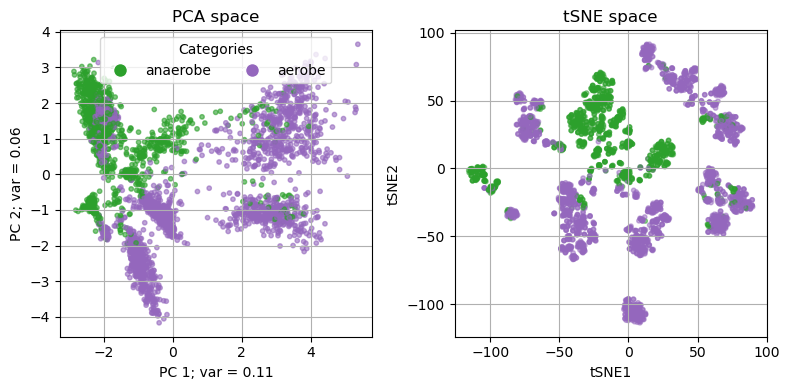

In [7]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X, n_compon, y, category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, y, colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by domain (bacteria vs archaea)**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788753 0.0074671  0.00698071 0.00635067 0.00614158
 0.00590522 0.00525625]
Total explained variance: 0.499964262523232
Shape of the projected data = (3161, 2)


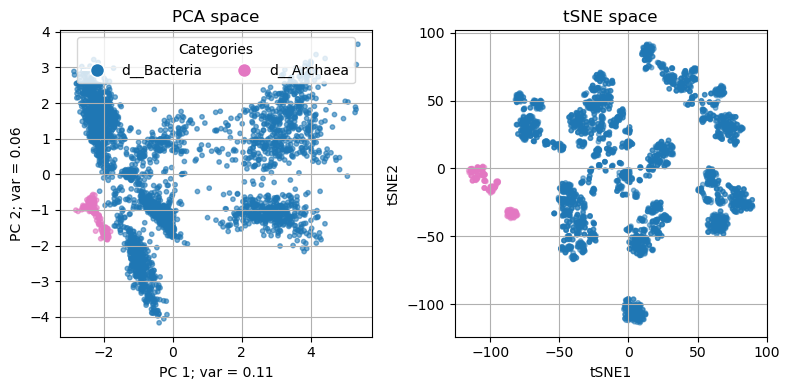

In [8]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:blue", "tab:pink"])
category_names = full_data['domain']
pca_run_and_plot(X, n_compon, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']],
                 category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']], colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by Phylum**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788749 0.00746712 0.00698073 0.00635077 0.00614166
 0.0059052  0.00525552]
Total explained variance: 0.49996368891348514
Shape of the projected data = (3161, 2)


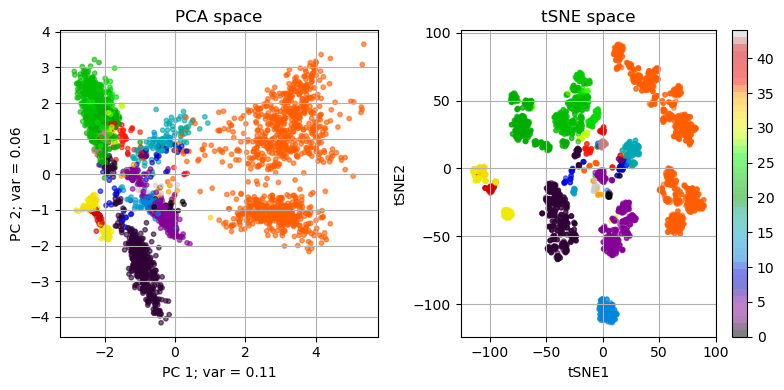

In [9]:
label_encoder = LabelEncoder()

plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = None
category_names = full_data['phylum']
pca_run_and_plot(X, n_compon, 
                 label_encoder.fit_transform(full_data['phylum']),
                 category_names, colors);
plt.legend().remove()
# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, 
          label_encoder.fit_transform(full_data['phylum']), 
          colors);


# Display the plots
plt.legend().remove()
plt.tight_layout()  
plt.show()

## 3. XGBoost training and feature selection

In [10]:
cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_train, y_train, X_test, y_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

XGBoost baseline test accuracy (all features) = {'accuracy': 0.9646772228989038, 'precision': np.float64(0.9639498432601881), 'recall': np.float64(0.9903381642512077), 'f1': np.float64(0.9769658459094519), 'roc_auc': np.float64(0.984194847020934)}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9646772228989038, 'precision': np.float64(0.9639498432601881), 'recall': np.float64(0.9903381642512077), 'f1': np.float64(0.9769658459094519), 'roc_auc': np.float64(0.984194847020934)}


### 3.1 Feature selection with Mutual Information

In [11]:
sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train.cpu(), y_train.cpu(), X_column_names)

In [12]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0109', 'COG1592', 'COG1612', 'COG0026', 'COG0276', 'COG0843', 'COG0508', 'COG0567', 'COG1328', 'COG1014']


Data after PCA reduction: (2340, 5)
Explained variance ratio: [0.61792636 0.08171205 0.06469174 0.05897061 0.04908598]
Total explained variance: 0.8723867361003128
Shape of the projected data = (2340, 2)


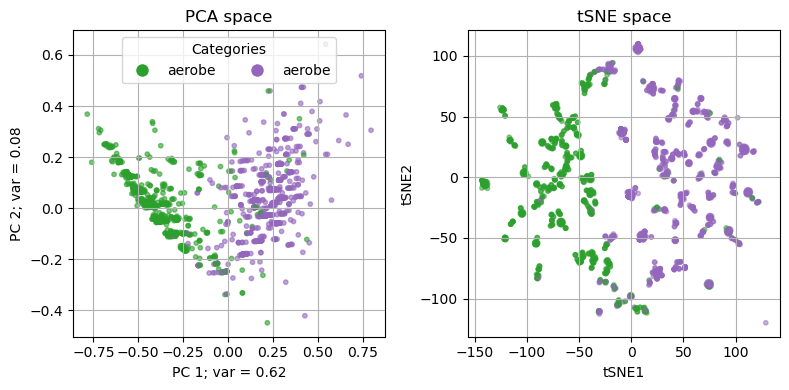

In [13]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()


In [14]:
y_label_train = y_train
y_label_test = y_test

X_val_train, X_val_test = X_train.cpu(), X_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [15]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.9371794871794872), 'precision': np.float64(0.9353330342900321), 'recall': np.float64(0.9683501683501683), 'f1': np.float64(0.9514305185045944), 'roc_auc': np.float64(0.9286313426664305)}
{'accuracy': 0.9037758830694276, 'precision': np.float64(0.9315286624203821), 'recall': np.float64(0.9420289855072463), 'f1': np.float64(0.9367493995196157), 'roc_auc': np.float64(0.8651046698872786)}


In [16]:
#TODO: rename x axis 
#TODO: move to utils
#DONE: add n_cols & reversed x axis for removing

def plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols):
    plt.axhline(y=test_accuracy_scores[metric], color='darkred', linestyle='--', linewidth=1.5, label='baseline test')
    plt.axhline(y=cv_accuracy_scores[metric], color='darkblue', linestyle='--', linewidth=1.5, label='baseline CV')

    plt.plot(num_feat, [scores[metric] for scores in test_accur_arr], c = "tab:red", label = "test | add")
    plt.plot(num_feat, [scores[metric] for scores in cv_accur_arr], c = "tab:blue", label = "cv | add")

    plt.plot([n_cols - n_feat for n_feat in num_feat],  [scores[metric] for scores in test_accur_arr_rem], c = "tab:red", label = "test | remove", alpha = 0.5)
    plt.plot([n_cols - n_feat for n_feat in num_feat], [scores[metric] for scores in cv_accur_arr_rem], c = "tab:blue", label = "cv | remove", alpha = 0.5)
    
    plt.xlabel("number of features added/removed")
    plt.ylabel(metric)

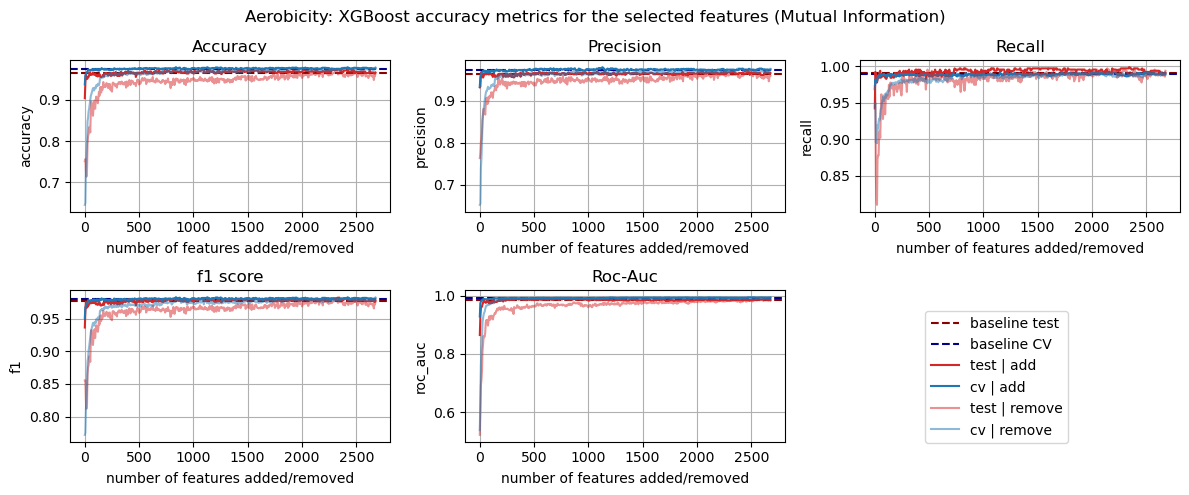

In [17]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Mutual Information)");

### 3.2 Feature selection with Random Forest

In [18]:
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

Original feature count: 2677, Selected feature count: 289


In [19]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG0109', 'COG0369', 'COG1328', 'COG0026', 'COG1592', 'COG1838', 'COG0567', 'COG0508', 'COG1612', 'COG0843']


In [20]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (2340, 5)
Explained variance ratio: [0.60393395 0.08977702 0.06865903 0.06404727 0.04890126]
Total explained variance: 0.8753185336760274
Shape of the projected data = (2340, 2)


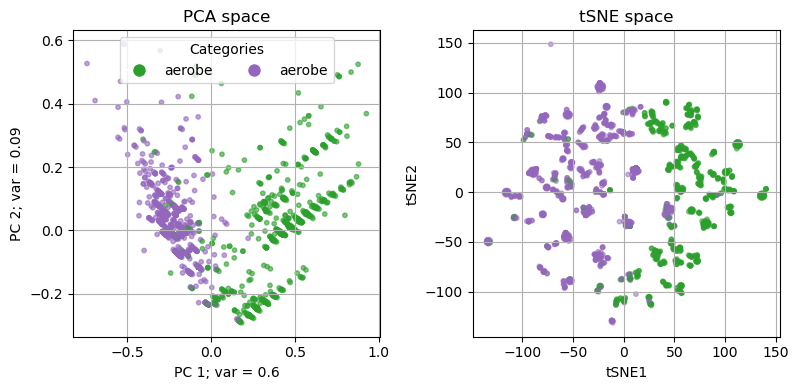

In [21]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [26]:
X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [27]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.9371794871794872), 'precision': np.float64(0.9353330342900321), 'recall': np.float64(0.9683501683501683), 'f1': np.float64(0.9514305185045944), 'roc_auc': np.float64(0.9286313426664305)}
{'accuracy': 0.9037758830694276, 'precision': np.float64(0.9315286624203821), 'recall': np.float64(0.9420289855072463), 'f1': np.float64(0.9367493995196157), 'roc_auc': np.float64(0.8651046698872786)}


Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)')

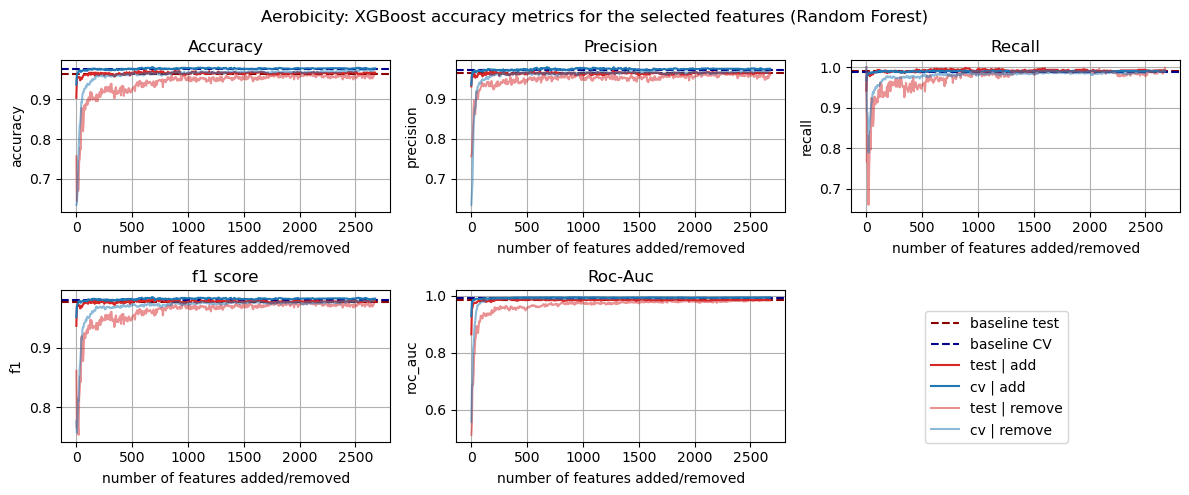

In [28]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)")

### 3.3 SHAP values

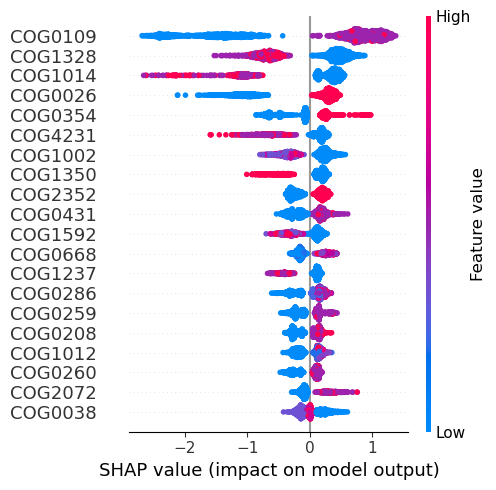

In [32]:
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, DEVICE) 

In [33]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG0109', 'COG1328', 'COG1014', 'COG0026', 'COG0354', 'COG4231', 'COG1002', 'COG1350', 'COG2352', 'COG0431']


Data after PCA reduction: (2340, 5)
Explained variance ratio: [0.50154209 0.18031783 0.09103514 0.06527138 0.04651315]
Total explained variance: 0.8846795918208689
Shape of the projected data = (2340, 2)


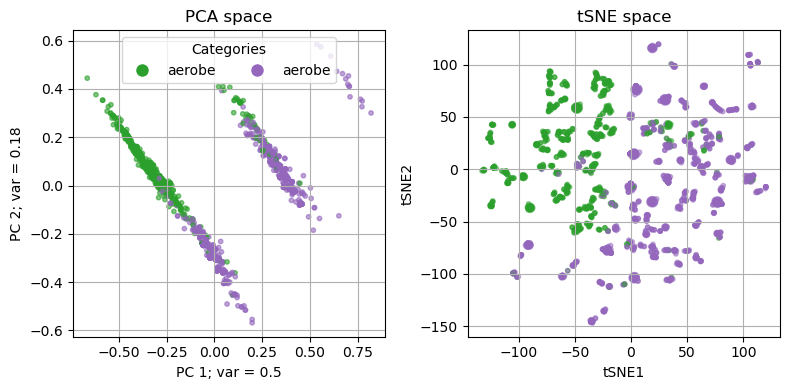

In [34]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']

pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [35]:
X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)')

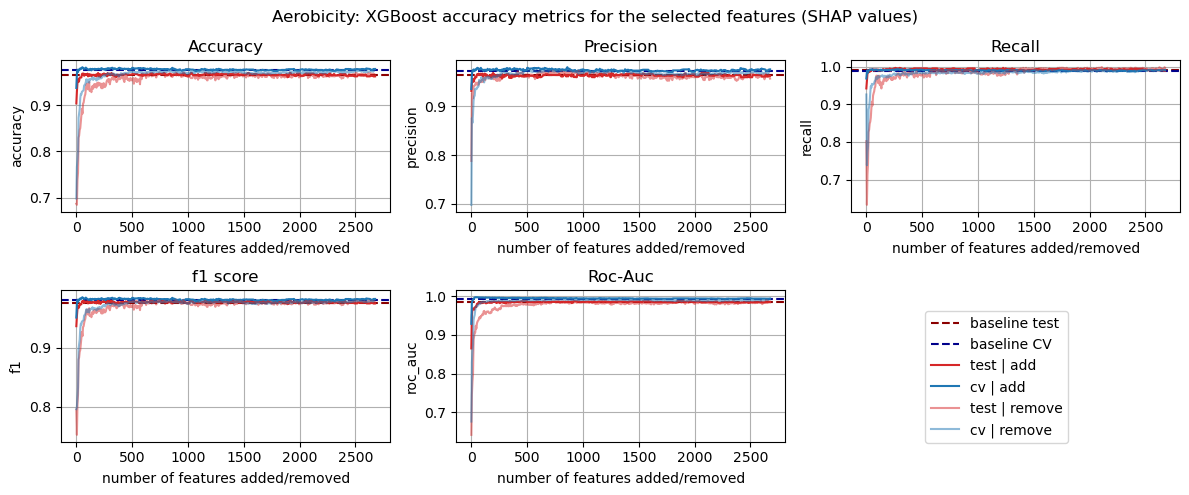

In [36]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)")

## 4. Feature comparison

In [40]:
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

df = pd.DataFrame(data)

df

,MI,RandomForest,SHAP
0,COG0109,COG0109,COG0109
1,COG1592,COG0369,COG1328
2,COG1612,COG1328,COG1014
3,COG0026,COG0026,COG0026
4,COG0276,COG1592,COG0354
5,COG0843,COG1838,COG4231
6,COG0508,COG0567,COG1002
7,COG0567,COG0508,COG1350
8,COG1328,COG1612,COG2352
9,COG1014,COG0843,COG0431


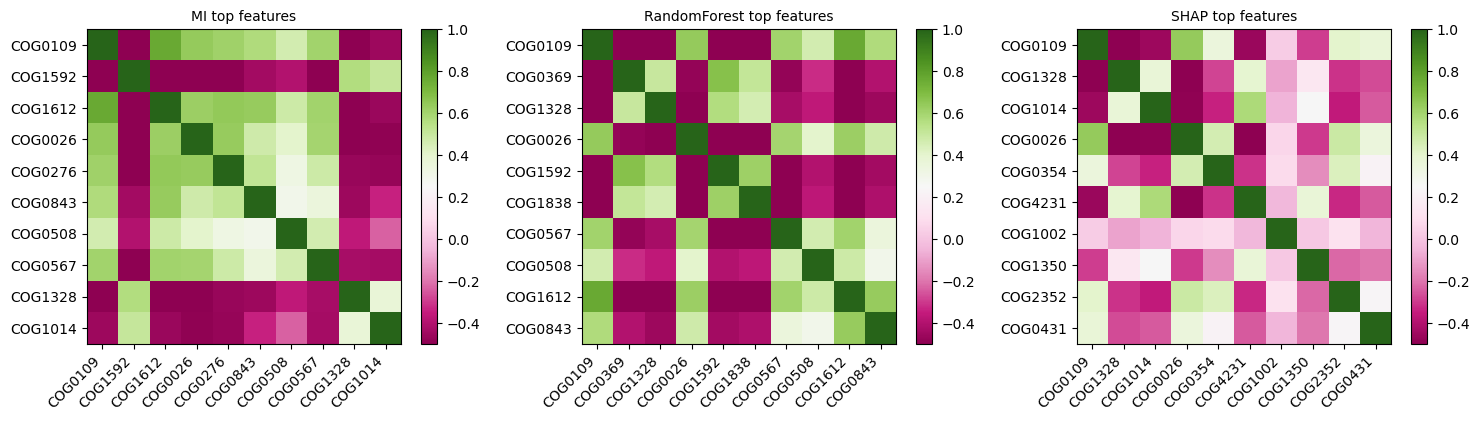

In [38]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.show()

In [45]:
r = requests.get('https://ftp.ncbi.nlm.nih.gov/pub/COG/COG2024/data/cog-24.def.tab')

cogs_descr = pd.DataFrame(columns=['COG_ID', 'Category', 'Description', 'Gene', 'Function', 'Gene_IDs', 'PDB_ID'])
data_lines = r.content.decode('utf-8').splitlines()

problematic_lines = []

for i, line in enumerate(data_lines):
    split = line.split('\t')
    if len(split) != 7:
        problematic_lines.append(line)
        # print(f"Line {i + 1} with {len(line.split('\t'))} splits: {line}")
    else:
        cogs_descr.loc[len(cogs_descr)] = split

In [73]:
df_descr = df.copy()

df_descr = pd.merge(df_descr, cogs_descr[['COG_ID', 'Description']], how='left', left_on=['MI'], right_on=['COG_ID'], suffixes=('', '_MI'))
df_descr = pd.merge(df_descr, cogs_descr[['COG_ID', 'Description']], how='left', left_on=['RandomForest'], right_on=['COG_ID'], suffixes=('', '_RandomForest'))
df_descr = pd.merge(df_descr, cogs_descr[['COG_ID', 'Description']], how='left', left_on=['SHAP'], right_on=['COG_ID'], suffixes=('', '_SHAP'))


df_descr['MI'] = df_descr['MI'] + ': ' + df_descr['Description']
df_descr['RandomForest'] = df_descr['RandomForest'] + ': ' + df_descr['Description_RandomForest']
df_descr['SHAP'] = df_descr['SHAP'] + ': ' + df_descr['Description_SHAP']
df_descr = df_descr[['MI', 'RandomForest', 'SHAP']]

df_descr

,MI,RandomForest,SHAP
0,COG0109: Polyprenyltransferase (heme O synthase),COG0109: Polyprenyltransferase (heme O synthase),COG0109: Polyprenyltransferase (heme O synthase)
1,COG1592: Rubrerythrin,COG0369: Flavoprotein (flavin reductase) subun...,COG1328: Anaerobic ribonucleoside-triphosphate...
2,COG1612: Heme A synthase,COG1328: Anaerobic ribonucleoside-triphosphate...,COG1014: Pyruvate:ferredoxin oxidoreductase or...
3,COG0026: Phosphoribosylaminoimidazole carboxyl...,COG0026: Phosphoribosylaminoimidazole carboxyl...,COG0026: Phosphoribosylaminoimidazole carboxyl...
4,COG0276: Protoheme ferro-lyase (ferrochelatase),COG1592: Rubrerythrin,"COG0354: Folate-binding protein YgfZ, synthesi..."
5,COG0843: Heme/copper-type cytochrome/quinol ox...,COG1838: Tartrate dehydratase beta subunit/Fum...,COG4231: TPP-dependent indolepyruvate ferredox...
6,COG0508: Pyruvate/2-oxoglutarate dehydrogenase...,"COG0567: 2-oxoglutarate dehydrogenase complex,...",COG1002: Type II restriction/modification syst...
7,"COG0567: 2-oxoglutarate dehydrogenase complex,...",COG0508: Pyruvate/2-oxoglutarate dehydrogenase...,COG1350: Predicted alternative tryptophan synt...
8,COG1328: Anaerobic ribonucleoside-triphosphate...,COG1612: Heme A synthase,COG2352: Phosphoenolpyruvate carboxylase
9,COG1014: Pyruvate:ferredoxin oxidoreductase or...,COG0843: Heme/copper-type cytochrome/quinol ox...,COG0431: NAD(P)H-dependent FMN reductase
